In [1]:
%run -i setup

c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:443: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:443: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))

IPython CPU timings (estimated):
  User   :     131.26 s.
  System :       0.00 s.
Wall time:     131.26 s.


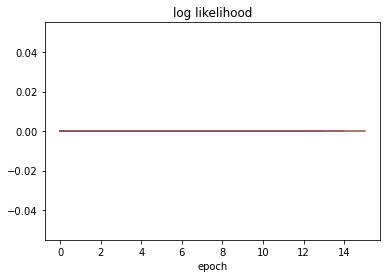

In [2]:
%run -i -t train

<Figure size 432x288 with 0 Axes>

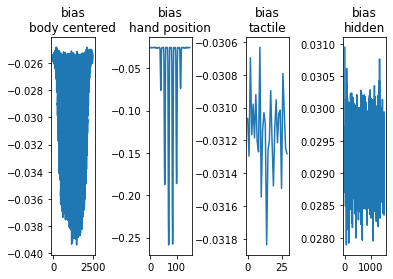

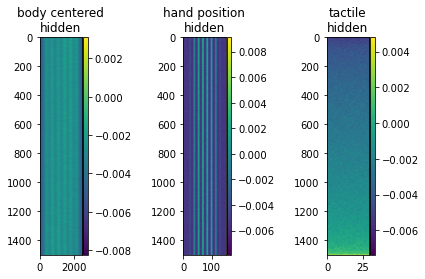

In [3]:
myw,myor = g.showPars(True)

In [4]:
## hand centered vs body centered tactile evoked activity
ntrials=10000
N_vects=100
ntrials=int(np.round(ntrials/N_vects)*N_vects)

nsteps=1
pBcs=np.zeros((ntrials,2))
pHs=np.zeros((ntrials,2))
pHcs=np.zeros((ntrials,2))
Ts=np.zeros((ntrials,1))
nGridPoints=17
stims=np.zeros((np.sum(g.NV),N_vects),dtype=float)
count=0
w=g.allW()
bh=g.allBh()
bv=g.allBv()
for i in np.arange(np.round(ntrials/N_vects)):
    if (i%10)==0:print(i)
    
    for v in np.arange(N_vects):
        count=count+1
        pBc=g.NeuronInfo[0].min+np.multiply(g.NeuronInfo[0].max-g.NeuronInfo[0].min,*np.random.rand(1,2))
        pH=g.NeuronInfo[1].min+np.multiply(g.NeuronInfo[1].max-g.NeuronInfo[1].min,*np.random.rand(1,2))
        gains=4+6*np.random.rand(3,1)
        Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
        T=0*T
        stims[:,v]=np.concatenate((Bc, H, T), axis=None)
        pBcs[count-1,:]=pBc
        pHs[count-1,:]=pH
        pHcs[count-1,:]=pBc-pH
    
    v=stims
    for s in np.arange(nsteps):
        #noiseless up and down passes, since we only care about averages
        #for the plots
        #up
        gv=w@v+bh
        mu=1.0/(1.0+np.exp(-gv))
        mu=mu.T
        h=mu.T
        #down
        gv=w.T@h+bv
        mu=np.exp(gv)
        v=mu
        v[0:-1-g.NV[2],:]=stims[0:-1-g.NV[2],:]
    Ts[int(i*N_vects):int((i+1)*N_vects),0]=np.nanmean(v[-1-g.NV[2]:-1,:],axis=0)


0.0
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:443: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:443: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


<Figure size 432x288 with 0 Axes>

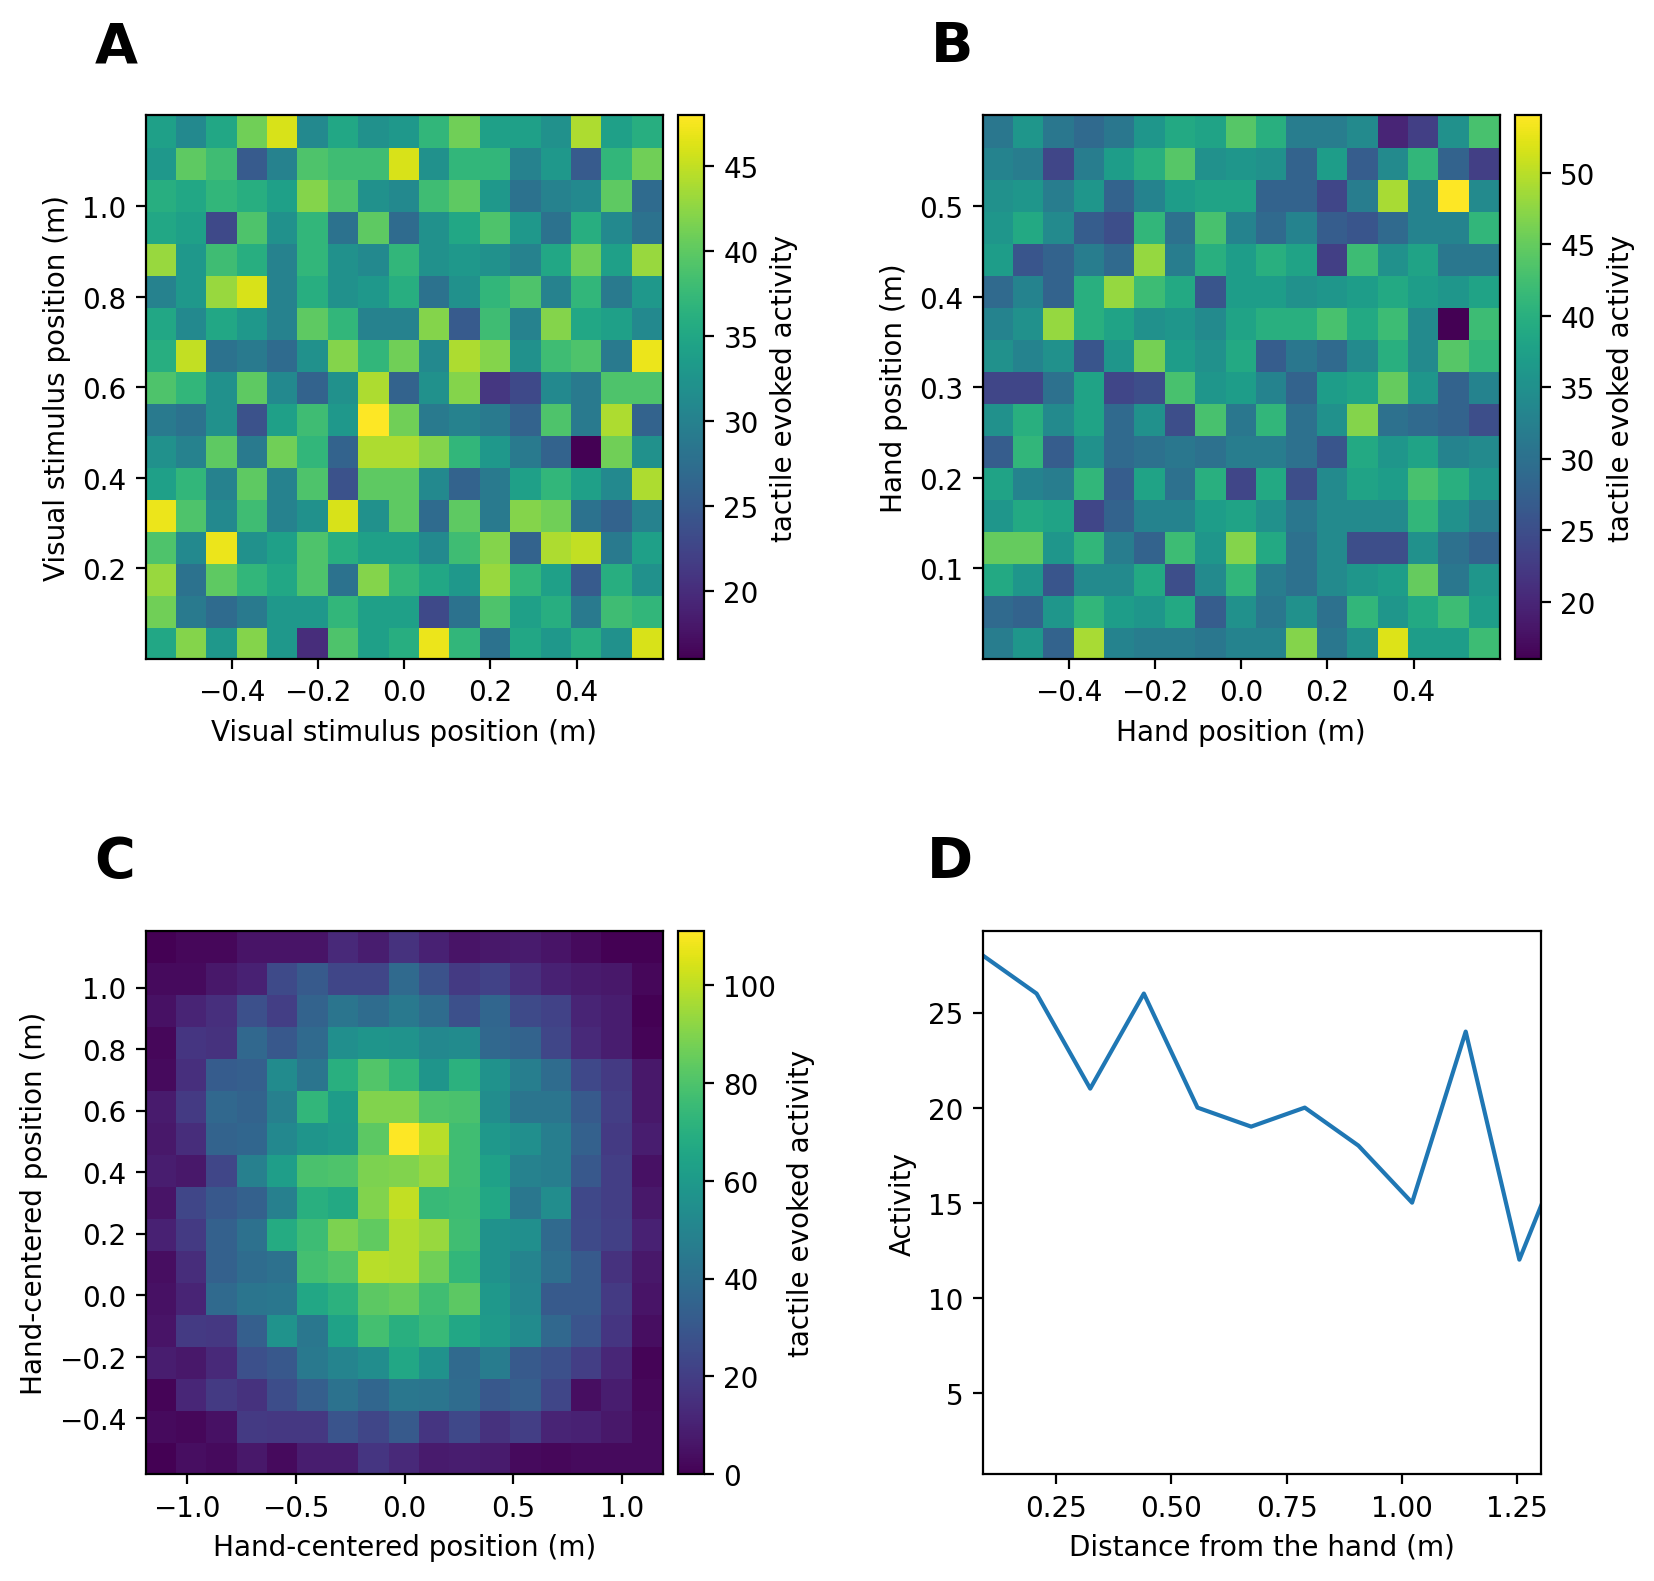

In [5]:
import string
import matplotlib as mpl
plt.figure(3)

fig, axs = plt.subplots(2, 2, figsize=(9, 9),dpi = 200)
ax1 = plt.subplot(221)
im1=ax1.hist2d(pBcs[:,0],pBcs[:,1],bins=nGridPoints)
ax1.set_xlabel('Visual stimulus position (m)')
ax1.set_ylabel('Visual stimulus position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im1[3],cax=cax,label='tactile evoked activity')
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, 
                size=20, weight='bold')

ax2 = plt.subplot(222)
im2=ax2.hist2d(pHs[:,0],pHs[:,1],bins=nGridPoints)
ax2.set_xlabel('Hand position (m)')
ax2.set_ylabel('Hand position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im2[3],cax=cax,label='tactile evoked activity')
ax2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax2.transAxes, 
                size=20, weight='bold')

ax3 = plt.subplot(223)
im3=ax3.hist2d(pHcs[:,0],pHcs[:,1],bins=nGridPoints)
ax3.set_xlabel('Hand-centered position (m)')
ax3.set_ylabel('Hand-centered position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im3[3],cax=cax,label='tactile evoked activity')
ax3.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax3.transAxes, 
                size=20, weight='bold')

ax4=plt.subplot(224)
xc=im3[1]
yc=im3[2]
xgrid,ygrid=np.meshgrid(xc,yc)
distances=np.concatenate(xgrid)**2+np.concatenate(ygrid)**2
distances_main=distances[(distances<np.percentile(distances,98))&(distances>np.percentile(distances,2))]
hist, bins = np.histogram(distances_main, bins=20)
center = (bins[:-1] + bins[1:]) / 2
ax4.plot(center,hist)
ax4.set_xlabel('Distance from the hand (m)')
ax4.set_ylabel('Activity')
minInd=np.min(np.abs(center))
maxInd=np.max(np.abs(center-1))
ax4.set_xlim([minInd,maxInd])
ax4.text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax4.transAxes, 
                size=20, weight='bold')

fig.subplots_adjust(wspace=0.5)      
fig.subplots_adjust(hspace=0.5)                

In [8]:
## proprioceptive drift
nPos=10
nRep=500
ntrials=nPos*nRep
nsteps=1
NV=g.NV
pBcs=np.zeros((ntrials,2))
pHs=np.zeros((ntrials,1))
pHcs=np.zeros((ntrials,2))
Ts=np.zeros((ntrials,1))
rBcs=np.zeros((g.NV[0],ntrials))
rHs=np.zeros((g.NV[1],ntrials))

positions=np.linspace(g.NeuronInfo[0].min[0],g.NeuronInfo[0].max[0],nPos)
tStrengths=[0,np.arange(4,10+1)]
maxPDs=[]
#colours=[0,0,0;jet( np.size(tStrengths-1) )]
tFlag=Ts
pH=[0,0.25]

plt.figure(4)
fig, axs = plt.subplots(1, 2, figsize=(9, 9),dpi = 200)

for ts in np.arange(np.size(tStrengths)):
    print(ts)
    tStrength=tStrengths[ts]
    count=0
    for p in np.arange(nPos):
        stims=np.zeros((np.sum(g.NV),nRep)) #again stimuli are noiseless since we only care about averages here
        for r in np.arange(nRep):
            count=count+1
            y=.6*np.random.rand()
            pBc=np.array([positions[p],y])
            pH=np.array([0,y])
            gains=4+6*np.random.rand(3,1)
            Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
            T=tStrength+0*T
            stims[:,r]=np.concatenate((Bc, H, T), axis=None)
            pBcs[count,:]=pBc
            pHs[count]=pH[0]
            pHcs[count,:]=pBc-pH
        
        for s in np.arange(nsteps):
            h,mymu=g.fastUp(stims)
            v,mymu=g.fastDown(h)
            stims[g.NV[0]:g.NV[0]+g.NV[1],:]=v[g.NV[0]:g.NV[0]+g.NV[1],:]
        cols=(p-1)*nRep+np.arange(p*nRep+1) # 1:p*nRep
        print(rHs[:,cols].shape)
        print(v[g.NV[0]:g.NV[0]+g.NV[1],:].shape)
        rHs[:,cols]=v[g.NV[0]:g.NV[0]+g.NV[1],:]
        rBcs[:,cols]=v[0:g.NV[0],:]
    
    touchedH=np.zeros((g.NV[1],nPos))
    nTouchedH=touchedH
    touchedBc=np.zeros((g.NV[0],nPos))
    nTouchedBc=touchedBc
    m=np.ceil(np.sqrt(nPos))
    n=np.round(nPos/m)
    tp=[]
    ntp=[]
    wx,wy=np.meshgrid(np.arange(g.NeuronInfo[1].n[0]),np.arange(g.NeuronInfo[1].n[1]),dtype=float)
    
    for p in np.arange(nPos):
        cols=(p-1)*nRep+np.arange(p*nRep+1)
        touchedH[:,p]=np.nanmean(rHs[:,cols],1)
        touchedBc[:,p]=np.mean(rBcs[:,cols],1)
        hCurr=rHs[:,cols]
        
        for i in np.arange(np.shape(hCurr,1)):
            w=np.flipud(np.rot90(np.reshape(hCurr[:,i],g.NeuronInfo[1].n)))
            barX=np.sum(np.sum(np.multiply(w,wx)))/np.sum(w[:])
            barY=np.sum(np.sum(np.multiply(w,wy)))/np.sum(w[:])
            tp[i,p]=barX
        
    plt.subplot(1,2,1)
    err=g.NeuronInfo[1].span[0]*np.nanstd(tp)/(g.NeuronInfo[1].n[0]*np.sqrt(np.shape(tp,0)))
    y=indToPos([np.nanmean(tp),0*np.nanmean(tp)].T,g.NeuronInfo[1])
    y=y[:,0].T
    maxPDs[ts]=np.max(y)
    
    ax1.plot(positions, 100*y) #, 'LineWidth',2,'color',colours(ts,:));
    
    ax1.plot(positions,np.zeros(np.shape(positions)),'k')    #'--','LineWidth',2,'color','k')
    ax1.plot([0,0],[np.min(y),np.max(y)],'k') #,'--','LineWidth',2,'color','k')
    ax1.set_xlabel('Visual input (m from midline)')
    ax1.set_ylabel('Proprioceptive drift (cm)')
    
    plt.subplot(1,2,2)
    err=g.NeuronInfo[1].span[0]*np.nanstd(tp)/(g.NeuronInfo[1].n[0]*np.sqrt(np.shape(tp,0)))
    y=indToPos([np.nanmean(tp),0*np.nanmean(tp)].T,g.NeuronInfo[1])
    y=y[:,0].T
    ax2.plot(positions,100*y/positions) # ,'LineWidth',2,'color',colours(ts,:));
    ax2.plot(positions,np.zeros(np.shape(positions)),'k') #'--','LineWidth',2,'color','k')
    plot([0,0],[np.min(y),np.max(y)],'k') #'--','LineWidth',2,'color','k')
    ax2.set_xlabel('Visual input (m from midline)')
    ax2.set_ylabel('Proprioceptive drift (%)')
    

plt.show()

C:\Users\renat\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:443: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:443: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
0
(150, 1)
(150, 500)


ValueError: shape mismatch: value array of shape (150,500) could not be broadcast to indexing result of shape (1,150)

In [ ]:
plt.figure(3)

plt.subplots(3,2,1)
plt.hist2d(pBcs[:,0],pBCs[:,1])


#grid,xc,yc=bindata2d(pBcs(:,1),pBcs(:,2),Ts,nGridPoints)
#imagesc(xc,yc,grid)
#cb=colorbar;
#xlabel('Visual stimulus position (m)')
#ylabel('Visual stimulus position (m)')
#ylabel(cb,'tactile evoked activity')
#set(gca,'YDir','normal')
#text(-0.25,1.1,'a','Units', 'Normalized', 'VerticalAlignment', 'Top','FontSize',18,'FontWeight','bold')

subplot(3,2,2)
[grid,xc,yc]=bindata2d(pHs(:,1),pHs(:,2),Ts,nGridPoints);
imagesc(xc,yc,grid)
cb=colorbar;
xlabel('Hand position (m)')
ylabel('Hand position (m)')
ylabel(cb,'Tactile evoked activity')
set(gca,'YDir','normal')
text(-0.25,1.1,'b','Units', 'Normalized', 'VerticalAlignment', 'Top','FontSize',18,'FontWeight','bold')


subplot(3,2,3)
[grid,xc,yc,stds,ns]=bindata2d(pHcs(:,1),pHcs(:,2),Ts,nGridPoints);
imagesc(xc,yc,grid)
cb=colorbar;
xlabel('Hand-centered position (m)')
ylabel('Hand-centered position (m)')
set(cb.Label,'Rotation',90);
ylabel(cb,'Tactile evoked activity')
set(gca,'YDir','normal')
text(-0.25,1.1,'c','Units', 'Normalized', 'VerticalAlignment', 'Top','FontSize',18,'FontWeight','bold')

subplot(3,2,4)
[xgrid,ygrid]=meshgrid(xc,yc);
distances=(xgrid(:).^2+ygrid(:).^2);
[xx,yy,~,sem]=bindata(distances,grid(:),20);
plot(xx,yy,'LineWidth',2)
[~,minInd]=min(abs(xx));
[~,maxInd]=min(abs(xx-1));
xlim([xx(minInd) xx(maxInd)])
cb=colorbar;
cb.Visible='off';
xlabel('Distance from the hand (m)')
ylabel('Activity')
text(-0.25,1.1,'d','Units', 'Normalized', 'VerticalAlignment', 'Top','FontSize',18,'FontWeight','bold')

## proprioceptive drift
nPos=10;
nRep=500;
ntrials=nPos*nRep;
nsteps=1;
NV=g.NV;
pBcs=zeros(ntrials,2);
pHs=zeros(ntrials,1);
pHcs=zeros(ntrials,2);
Ts=zeros(ntrials,1);
rBcs=zeros(g.NV(1),ntrials);
rHs=zeros(g.NV(2),ntrials);

positions=linspace(g.NeuronInfo(1).min(1),g.NeuronInfo(1).max(1),nPos);
tStrengths=[0, 4:10];
maxPDs=[];
colours=[0,0,0;jet(numel(tStrengths-1))];
tFlag=Ts;
pH=[0,0.25];

for ts=1:numel(tStrengths)
    ts
    tStrength=tStrengths(ts);
    count=0;
    for p=1:nPos
        stims=zeros(sum(g.NV),nRep); %again stimuli are noiseless since we only care about averages here
        for r=1:nRep
            count=count+1;
            y=.6*rand;
            pBc=[positions(p),y];
            pH=[0,y];
            gains=4+6*rand(3,1);
            [Bc, H, T]=stimgen(pBc,pH,g.NeuronInfo,gains);
            T=tStrength+0*T;
            stims(:,r)=[Bc; H; T];
            pBcs(count,:)=pBc;
            pHs(count)=pH(1);
            pHcs(count,:)=pBc-pH;
        end
        
        for s=1:nsteps
            [~,h]=g.fastUp(stims);
            [~,v]=g.fastDown(h);
            stims(g.NV(1):g.NV(1)+g.NV(2)-1,:)=v(g.NV(1):g.NV(1)+g.NV(2)-1,:);
        end
        cols=(p-1)*nRep+1:p*nRep;
        rHs(:,cols)=v(g.NV(1)+1:g.NV(1)+g.NV(2),:);
        rBcs(:,cols)=v(1:g.NV(1),:);
    end
    
    touchedH=zeros(g.NV(2),nPos);
    nTouchedH=touchedH;
    touchedBc=zeros(g.NV(1),nPos);
    nTouchedBc=touchedBc;
    m=ceil(sqrt(nPos));
    n=round(nPos/m);
    tp=[];
    ntp=[];
    [wx,wy]=meshgrid(1:g.NeuronInfo(2).n(1),1:g.NeuronInfo(2).n(2));
    
    for p=1:nPos
        cols=(p-1)*nRep+1:p*nRep;
        touchedH(:,p)=nanmean(rHs(:,cols),2);
        touchedBc(:,p)=mean(rBcs(:,cols),2);
        hCurr=rHs(:,cols);
        
        for i=1:size(hCurr,2)
            w=flipud(rot90(reshape(hCurr(:,i),g.NeuronInfo(2).n)));
            barX=sum( sum(w.*wx)) /sum(w(:));
            barY=sum(sum(w.*wy))/sum(w(:));
            tp(i,p)=barX;
        end
    end
    
    subplot(3,2,5)
    err=g.NeuronInfo(2).span(1)*nanstd(tp)./(g.NeuronInfo(2).n(1)*sqrt(size(tp,1)));
    y=indToPos([nanmean(tp);0*nanmean(tp)]',g.NeuronInfo(2));
    y=y(:,1)';
    maxPDs(ts)=max(y);
    plot(positions, 100*y, 'LineWidth',2,'color',colours(ts,:));
    hold on
    plot(positions,zeros(size(positions)),'--','LineWidth',2,'color','k')
    plot([0 0],[min(y) max(y)],'--','LineWidth',2,'color','k')
    xlabel('Visual input (m from midline)')
    ylabel('Proprioceptive drift (cm)')
    
    subplot(3,2,6)
    err=g.NeuronInfo(2).span(1)*nanstd(tp)./(g.NeuronInfo(2).n(1)*sqrt(size(tp,1)));
    y=indToPos([nanmean(tp);0*nanmean(tp)]',g.NeuronInfo(2));
    y=y(:,1)';
    plot(positions, 100*y./positions, 'LineWidth',2,'color',colours(ts,:));
    hold on
    plot(positions,zeros(size(positions)),'--','LineWidth',2,'color','k')
    plot([0 0],[min(y) max(y)],'--','LineWidth',2,'color','k')
    xlabel('Visual input (m from midline)')
    ylabel('Proprioceptive drift (%)')
    
end
##
subplot(3,2,5)
colormap(gca,colours);
cb=colorbar('eastoutside');
cb.Ticks=linspace(0+.5/numel(tStrengths),1-.5/numel(tStrengths),numel(tStrengths));
cb.TickLabels=tStrengths;
cb.Label.String='Tactile input strength';
cb.TickLength=0;
xlim([min(positions),max(positions)])
text(-0.25,1.1,'e','Units', 'Normalized', 'VerticalAlignment', 'Top','FontSize',18,'FontWeight','bold')

subplot(3,2,6)
colormap(gca,colours);
cb=colorbar('eastoutside');
cb.Ticks=linspace(0+.5/numel(tStrengths),1-.5/numel(tStrengths),numel(tStrengths));
cb.TickLabels=tStrengths;
cb.Label.String='Tactile input strength';
cb.TickLength=0;
xlim([min(positions),max(positions)])
text(-0.25,1.1,'f','Units', 'Normalized', 'VerticalAlignment', 'Top','FontSize',18,'FontWeight','bold')
